In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 超参数
epochs = 200
batch_size = 128
learning_rate = 0.001
timesteps = 1000
img_size = 28
channels = 1

# 数据加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 模型定义
# class SimpleUnet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(SimpleUnet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x1 = self.relu(self.conv1(x))
#         x2 = self.relu(self.conv2(x1))
#         out = self.conv3(x2)
#         return out
class SimpleUnet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # Use the SiLU activation function, which has been shown to work well
        # due to different properties (smoothness, non-monotonicity, etc.).
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))

        return x


# 生成噪声函数
def generate_noise(shape):
    return torch.randn(shape)

# 线性噪声调度
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]])

# 样本反向生成过程
def sample(model, n_samples, timesteps, shape):
    model.eval()
    samples = generate_noise((n_samples, *shape))
    for t in reversed(range(timesteps)):
        t_tensor = torch.full((n_samples,), t, dtype=torch.long)
        mean, var = predict_noise(model, samples, t_tensor)
        samples = mean + torch.sqrt(var) * torch.randn_like(samples)
    return samples

# 预测噪声
def predict_noise(model, x_t, t):
    betas_t = betas[t].view(-1, 1, 1, 1)
    alphas_cumprod_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    alphas_cumprod_prev_t = alphas_cumprod_prev[t].view(-1, 1, 1, 1)
    pred_noise = model(x_t)
    mean = (1 / torch.sqrt(alphas[t])) * (x_t - betas_t / torch.sqrt(1 - alphas_cumprod_t) * pred_noise)
    var = betas_t * (1 - alphas_cumprod_prev_t) / (1 - alphas_cumprod_t)
    return mean, var

# 训练模型
def train(model, dataloader, optimizer, timesteps):
    model.train()
    mse_loss = nn.MSELoss()
    for epoch in range(epochs):
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            t = torch.randint(0, timesteps, (images.size(0),), device=device)
            noise = generate_noise(images.shape).to(device)
            noisy_images = (torch.sqrt(alphas_cumprod[t].view(-1, 1, 1, 1)) * images +
                            torch.sqrt(1 - alphas_cumprod[t].view(-1, 1, 1, 1)) * noise)
            optimizer.zero_grad()
            predicted_noise = model(noisy_images)
            loss = mse_loss(predicted_noise, noise)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# 初始化和训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleUnet(channels, channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(model, train_loader, optimizer, timesteps)

# 生成样本
samples = sample(model, 28, timesteps, (channels, img_size, img_size)).cpu().detach()
samples = (samples + 1) / 2  # 恢复到[0, 1]范围

# 显示生成的样本
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


Epoch 1/200, Loss: 0.3961


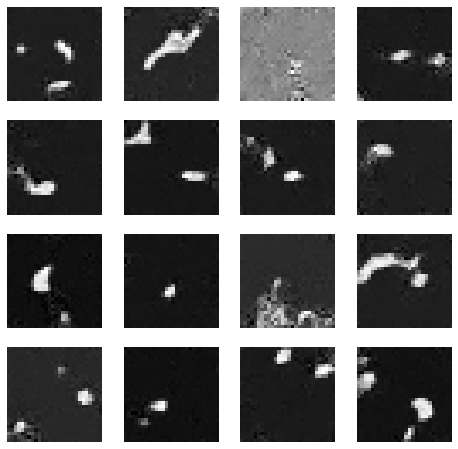

In [2]:
# 生成样本
samples = sample(model, 28, timesteps, (channels, img_size, img_size)).cpu().detach()
samples = (samples + 1) / 2  # 恢复到[0, 1]范围

# 显示生成的样本
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()
